In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' % x)
pd.set_option('display.width', 200)


In [2]:
df = pd.read_csv("amazon.csv")

In [3]:
df.head(10)

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...
5,5,0,Not for us,Looks different then photo
6,5,0,Perfect for spa room,Was exactly what i was looking for. Heavy mate...
7,5,0,Actually better than expected,"Looking at the picture, I thought these curtai..."
8,4,0,Not what expected,Much whiter than I thought it would be and was...
9,5,0,Pretty as a Picture,These are curtains just as the picture shows. ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


# 1- ) Text Preprocessing

### a) Normalizing Case Folding

In [5]:
df['Review'] = df['Review'].str.lower()

In [6]:
df['Review'].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object

### b) Punctuations

In [7]:
df['Review'] = df['Review'].str.replace( '[^\w\s]', ' ', regex=True)

df['Review'].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows  br   imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can t believe the qu...
Name: Review, dtype: object

### c) Numbers

In [8]:
df['Review'] = df['Review'].str.replace( '\d', ' ', regex=True)

In [9]:
df['Review'].head(10)

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows  br   imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can t believe the qu...
5                           looks different then photo
6    was exactly what i was looking for  heavy mate...
7    looking at the picture  i thought these curtai...
8    much whiter than i thought it would be and was...
9    these are curtains just as the picture shows  ...
Name: Review, dtype: object

### d) StopWords

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ekesk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
sw = stopwords.words('english')

In [12]:
sw[0:5]

['i', 'me', 'my', 'myself', 'we']

In [13]:
df['Review'] = df['Review'].apply(lambda x: " ".join((x for x in str(x).split() if x not in sw)))

In [14]:
df['Review'].head()

0                                                happy
1     good quality material however panels mis matched
2    product fun bedroom windows br imagery bit str...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

### Rare Words / Custom Words

In [15]:
# Let's remove words that occur less than 1000 times from the text.

temp_df = pd.Series( ' '.join(df['Review']).split()).value_counts()[1000:]

In [16]:
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in temp_df))

### Lemmatization

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ekesk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [19]:
df['Review'].head(10)

0                                                happy
1          good quality material however panel matched
2    product fun bedroom window br bit stretched st...
3                                         que e que un
4    great believe quality material vibrant color s...
5                                 look different photo
6      exactly looking heavy material great price fast
7    looking picture thought curtain would thinner ...
8              much thought would really expecting use
9    curtain picture show set ambesonne curtain one...
Name: Review, dtype: object

# 2-) Text Visualization

### Bar Plot

In [20]:
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [21]:
tf.columns = ["words", "tf"]

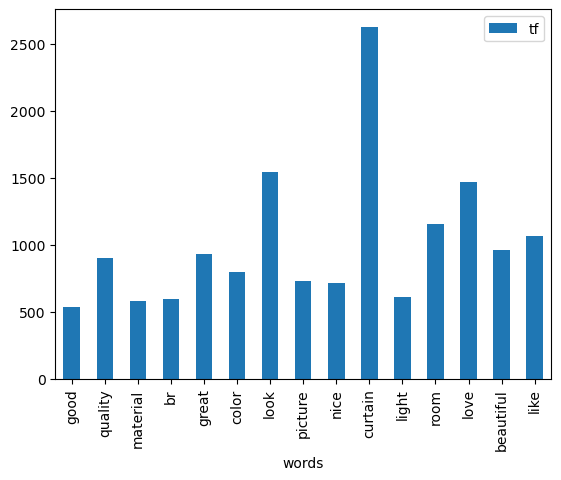

In [22]:
tf[tf['tf'] > 500].plot.bar(x="words", y="tf")
plt.show()

## Word Cloud

In [23]:
text = " ".join(i for i in df.Review)

In [24]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

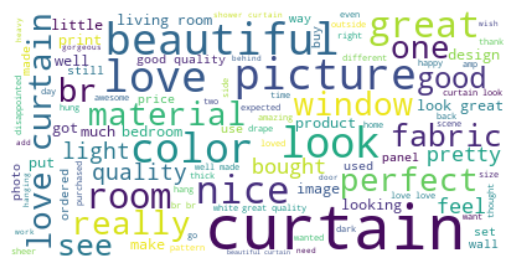

In [25]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3-) Sentiment Analysis

In [26]:
sia=SentimentIntensityAnalyzer()

In [27]:
df['Review'][0:10].apply(lambda x:sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...
7    {'neg': 0.0, 'neu': 0.564, 'pos': 0.436, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'comp...
Name: Review, dtype: object

In [28]:
df['Review'][0:10].apply(lambda x:sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.77
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [29]:
df['Review'][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [30]:
df['Sentiment Label'] = df['Review'].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [31]:
df.groupby('Sentiment Label')['Star'].mean()

Sentiment Label
neg   3.48
pos   4.56
Name: Star, dtype: float64

In [32]:
# Dependent variable for comment classification machine learning model by tagging comments with SentimentIntensityAnalyzer has been created.

# 4-) Preperation for Machine Learning

In [33]:
# Let's separate the data into test and train.

train_x, test_x, train_y, test_y = train_test_split(df['Review'], df['Sentiment Label'], random_state=42)

### TF-IDF Word Level

In [34]:
# Converting text to numerical variables
tf_idf_word_vectorizer = TfidfVectorizer()
X_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

# 5) Machine Learning Model

### a) Logistic Regression

In [35]:
log_model = LogisticRegression().fit(X_train_tf_idf_word, train_y)

In [36]:
y_pred = log_model.predict(X_test_tf_idf_word)

In [37]:
# recall: shows how many of the data a model classifies as positive are actually positive
# precision:  shows how many of the data a model classifies as positive are actually positive.
# f1 score: harmonic mean of precision and recall

print(classification_report(y_pred, test_y))    

              precision    recall  f1-score   support

         neg       0.36      0.96      0.53        81
         pos       1.00      0.90      0.94      1322

    accuracy                           0.90      1403
   macro avg       0.68      0.93      0.74      1403
weighted avg       0.96      0.90      0.92      1403



In [38]:
cross_val_score(log_model, X_test_tf_idf_word, test_y, cv=5).mean()

0.8688612099644129

In [39]:
random_review = pd.Series(df['Review'].sample(1).values)

In [40]:
random_review

0    disappointed received instead correct product
dtype: object

In [41]:
# Converting the new comment line to numeric variables
new_random_review = CountVectorizer().fit(train_x).transform(random_review)

In [42]:
pred = log_model.predict(new_random_review)

In [43]:
print(f'Review:{random_review[0]} \n Prediction: {pred}')

Review:disappointed received instead correct product 
 Prediction: ['neg']


### b) Random Forest

In [44]:
rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, train_y)

In [45]:
cross_val_score(rf_model, X_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.9109201830198271